# Figures S32, S33, and S34

This notebook loads the data and produces figure S32, S33, and S34.

In [1]:
plotsavedate='20251031'

In [2]:
path_to_analysis_folder = '' # path to analysis folder
data_folder = '' # path to data
path_to_figures_folder = '' # path to figures folder

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
import json
import os
import copy
from matplotlib.colors import LinearSegmentedColormap

## Load data

In [4]:
os.chdir(path_to_analysis_folder)
from clustering_allUS_preprocessing import ClusteringData

In [5]:
string_cols = ['unique_ID', 'Station Name', 'Street Address', 'Intersection Directions', 'City', 'State_abbr', 'ZIP',  'Status Code', 'EV Network', 'Owner Type Code', 'Open Date',  'EV Pricing', 'Facility Type', 'Groups With Access Code',  'Access Days Time', 'COUNTYNAME', 'State',  'clostestname_PoI', 'clostestname_ind', 'clostestname_topcat', 'utility', 'utilitytype', 'STATEFP']
dtype_dict = {i:'string' for i in string_cols}
dataobj = ClusteringData(savedate=plotsavedate)
combined_df_stations = pd.read_csv(data_folder + '20_level_stations_US_compiled_250415.zip', index_col=0,
                                   dtype=dtype_dict, usecols=dataobj.cols_cluster+['unique_ID', 'State', 'BGFP', 'TRACTFP', 'STATEFP', 'COUNTYFP', 'raw_visit_counts', 'total_pop_byBG'])
dataobj.df = combined_df_stations.copy()
dataobj.clean()
dataobj.normalize()
dataobj.transform(save=False)

# Figure S32

In [6]:
# Model for dendrogram 1
agglo1 = cluster.FeatureAgglomeration(n_clusters=16, 
                                           compute_distances=True, 
                                           linkage='complete')
model1 = agglo1.fit(dataobj.X_std_df)

# Model for dendrogram 2
agglo2 = cluster.FeatureAgglomeration(n_clusters=13, 
                                           compute_distances=True, 
                                           linkage='ward') 
model2 = agglo2.fit(dataobj.X_std_df)

# Selection of K based on dendrogram 2 (using ward's method)
nc = 8
agglo3 = cluster.FeatureAgglomeration(n_clusters=nc, 
                                      compute_distances=True, 
                                      linkage='ward') 
model3 = agglo3.fit(dataobj.X_std_df)
y_std = model3.transform(dataobj.X_std_df)

# Interpret feature groupings
# for i in range(8):
#     print('Cluster '+str(i)+':')
#     print(list([dataobj.cols_cluster[k] for k in np.where(model3.labels_ == i)[0]]))
feature_cluster_names = {0:'Weekday/daytime',
                         1:'Dense city',
                         2:'Weekend/evening, restaurants and shopping',
                         3:'Car suburbs',
                         4:'Hotels', 
                         5:'Big houses', 
                         6:'Gas stations', 
                         7:'Schools and parks'}

In [7]:
def plot_dendrogram_v3(model, truncate_mode, p, ax=None, cols=None, color_threshold=None, name_dict=None, label_font=10):
    
    if name_dict is None:
        name_dict = {col:col for col in cols}
        
    labels = [name_dict[col] for col in cols]
    p = len(cols)
    truncate_mode = truncate_mode

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dend1 = dendrogram(linkage_matrix, truncate_mode=truncate_mode, p=p, ax=ax, no_plot=True, color_threshold=color_threshold, above_threshold_color='slategrey')
    
    temp = {dend1["leaves"][ii]: labels[dend1["leaves"][ii]] for ii in range(len(dend1["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])

    dend2 = dendrogram(
            linkage_matrix,
            truncate_mode=truncate_mode,
            p=p,
            leaf_label_func=llf,
            orientation='left',
            leaf_rotation=0.,
            leaf_font_size=label_font,
            show_contracted=True,
            color_threshold=color_threshold,
            above_threshold_color='dimgrey',
            ax=ax
            )
    
    return dend2

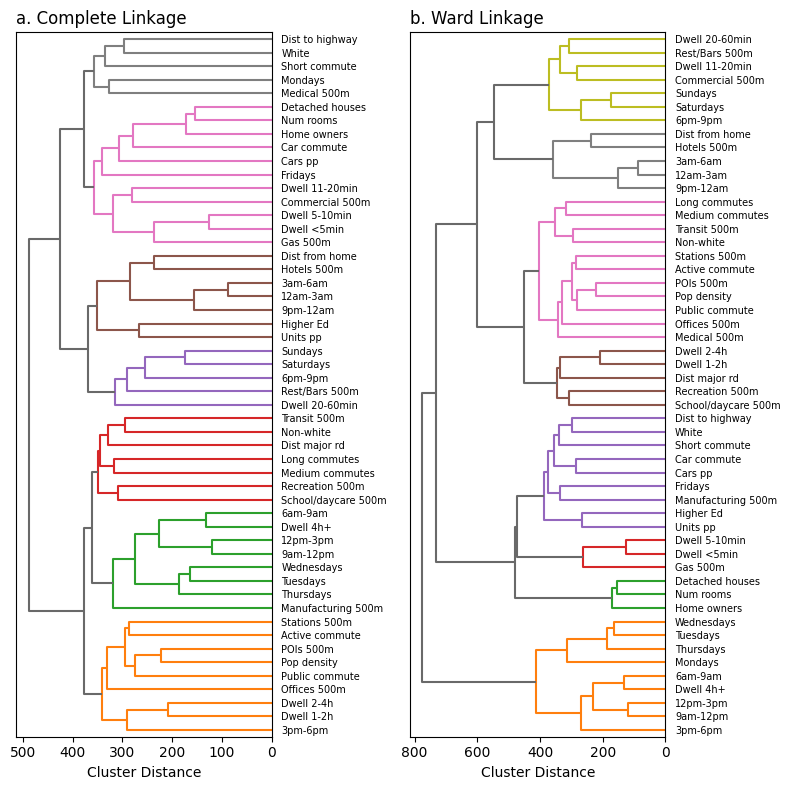

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
dend = plot_dendrogram_v3(model1, truncate_mode=None, p=16, cols=dataobj.cols_cluster, color_threshold=360, name_dict=dataobj.col_renaming, ax=axes[0], label_font=7)
dend = plot_dendrogram_v3(model2, truncate_mode=None, p=13, cols=dataobj.cols_cluster, color_threshold=420, name_dict=dataobj.col_renaming, ax=axes[1], label_font=7)
axes[0].set_title('a. Complete Linkage', loc='left')
axes[0].set_xlabel('Cluster Distance')
axes[1].set_title('b. Ward Linkage', loc='left')
axes[1].set_xlabel('Cluster Distance')
plt.tight_layout()
plt.savefig(path_to_figures_folder + 'Figures/figureS32_dendrograms_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.savefig(path_to_figures_folder + 'Figures/figureS32_dendrograms_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()

# Figure S33

In [9]:
# Calculate inertias for different K
distorsions = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, n_init=k)
    kmeans.fit(y_std)
    distorsions.append(kmeans.inertia_)
    
# Approximate derivatives
d1 = [int(distorsions[i+1]) - int(distorsions[i]) for i in range(len(distorsions)-1)]
d2 = [int(d1[i+1]) - int(d1[i]) for i in range(len(d1)-1)]

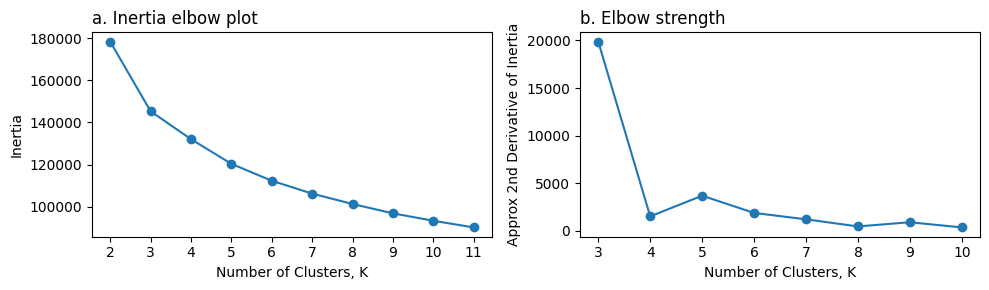

In [10]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(np.arange(2, 12), distorsions, '-o')
plt.xlabel('Number of Clusters, K')
plt.xticks(np.arange(2, 12))
plt.ylabel('Inertia')
plt.title('a. Inertia elbow plot', loc='left')
plt.subplot(122)
plt.plot(np.arange(3, 11), d2, '-o')
plt.xlabel('Number of Clusters, K')
plt.xticks(np.arange(3, 11))
plt.ylabel('Approx 2nd Derivative of Inertia')
plt.title('b. Elbow strength', loc='left')
plt.tight_layout()
plt.savefig(path_to_figures_folder + 'Figures/figureS33_alternativeclustering1_elbow_plot_nice_'+plotsavedate+'.pdf', bbox_inches='tight', dpi=400)
plt.savefig(path_to_figures_folder + 'Figures/figureS33_alternativeclustering1_elbow_plot_nice_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()

# Figure S34

In [11]:
nc1 = 8 # Feature clusters
nc2_1 = 5 # Station clusters - option 1
nc2_2 = 7 # Station clusters - option 2

# Clustering
feature_cluster_names_list = [feature_cluster_names[i] for i in range(nc1)]
kmeans1 = KMeans(n_clusters=nc2_1, random_state=0, n_init=nc2_1).fit(y_std)
df_kmeans_centers1 = pd.DataFrame(kmeans1.cluster_centers_, columns=feature_cluster_names_list)
kmeans2 = KMeans(n_clusters=nc2_2, random_state=0, n_init=nc2_2).fit(y_std)
df_kmeans_centers2 = pd.DataFrame(kmeans2.cluster_centers_, columns=feature_cluster_names_list)

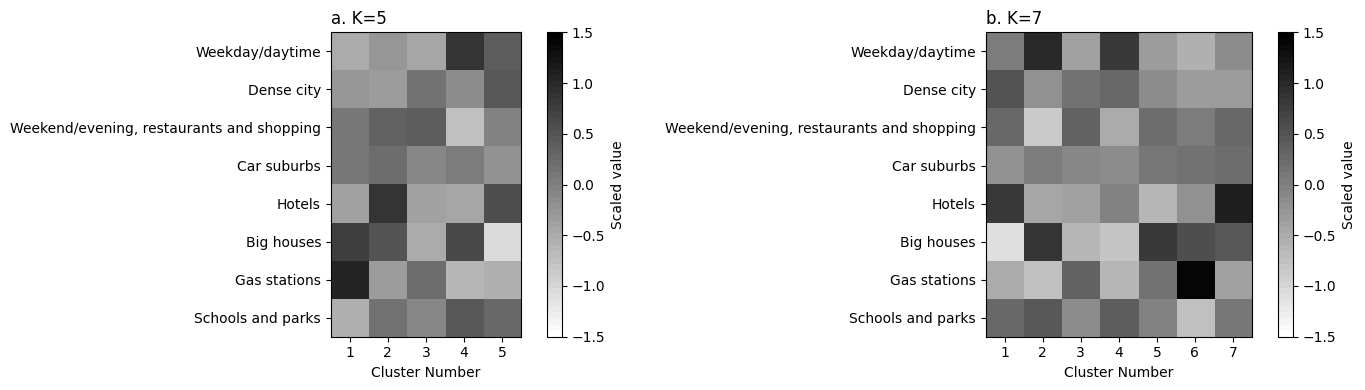

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
cmap = LinearSegmentedColormap.from_list('Cmap_grey', ['white', 'k'], N=50)

pos = axes[0].imshow((df_kmeans_centers1).T, cmap=cmap, vmin=-1.5, vmax=1.5)
fig.colorbar(pos, ax=axes[0], label='Scaled value')
axes[0].set_yticks(range(nc1))
axes[0].set_yticklabels(feature_cluster_names_list, rotation=0)
axes[0].set_xticks(range(nc2_1))
axes[0].set_xticklabels((1+np.arange(nc2_1)).astype(int))
axes[0].set_xlabel('Cluster Number')
axes[0].set_title('a. K='+str(nc2_1), loc='left')

pos = axes[1].imshow((df_kmeans_centers2).T, cmap=cmap, vmin=-1.5, vmax=1.5)
fig.colorbar(pos, ax=axes[1], label='Scaled value')
axes[1].set_yticks(range(nc1))
axes[1].set_yticklabels(feature_cluster_names_list, rotation=0)
axes[1].set_xticks(range(nc2_2))
axes[1].set_xticklabels((1+np.arange(nc2_2)).astype(int))
axes[1].set_xlabel('Cluster Number')
axes[1].set_title('b. K='+str(nc2_2), loc='left')

plt.tight_layout()
plt.savefig(path_to_figures_folder + 'Figures/figureS34_alternativeclustering1_centers_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.savefig(path_to_figures_folder + 'Figures/figureS34_alternativeclustering1_centers_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()